In [1]:
# libraries for building convolutional neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# libraries for tuning models
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
import keras

from keras_tuner import HyperParameters
from tensorflow.keras import backend as K
from keras.callbacks import History, EarlyStopping
from tensorflow.keras.regularizers import l2


# utility libraries
import os
import time
import itertools
import random
import numpy as np
import sys
import shutil
from pathlib import Path


# our commonly used functions
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)

# Now import the module
from global_bug_bot_functions import *
from data_processing_pipeline import *


# Force TensorFlow to use GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')  # Use only the first GPU
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU.")


# Set random seeds for reproducibility
seed_value = 2025
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
keras.utils.set_random_seed(seed_value)

# data set constants

ALL_PROCESSED_DATA = "PROCESSED_DATA/"
VALIDATION_DATA = f'{ALL_PROCESSED_DATA}VALIDATION_DATA/'
TEST_DATA = f'{ALL_PROCESSED_DATA}TEST_DATA/'
TRAINING_DATA = f'{ALL_PROCESSED_DATA}TRAINING_DATA/'
AUGMENTED_OUTPUT_DIR = f'{TRAINING_DATA}TRAINING_AUGMENTED_DATA/'

TRAIN_GENERATOR = load_data(f'PROCESSED_DATA/TRAINING_DATA/TRAINING_AUGMENTED_DATA/')
VAL_GENERATOR = load_data(f'PROCESSED_DATA/VALIDATION_DATA/')
TEST_GENERATOR = load_data(f'PROCESSED_DATA/TEST_DATA/', shuffle_flag=False)
EVAL_VAL_GENERATOR = load_data(f'PROCESSED_DATA/VALIDATION_DATA/', shuffle_flag=False)

# hold training+validation augmented data for final model
COMBINED_TRAINING = "../COMBINED_TRAINING/" 
os.makedirs(COMBINED_TRAINING, exist_ok=True)

AUGMENTED_VALID = '../AUGMENTED_VALID/'
os.makedirs(AUGMENTED_VALID, exist_ok=True)


# ---- AUGMENT VALIDATION PRIOR TO JOINING WITH TRAINING ----

successfully_augmented = 0
for folder in get_folders(f'PROCESSED_DATA/VALIDATION_DATA/'):
    source_dir = os.path.join(VALIDATION_DATA, folder)  # FIXED PATH

    if not os.path.exists(source_dir):
        print(f"Skipping missing directory: {source_dir}")
        continue

    output_subdir = os.path.join(AUGMENTED_VALID, folder)
    os.makedirs(output_subdir, exist_ok=True)

    for file in os.listdir(source_dir):
        file_path = os.path.join(source_dir, file)


        # saving info needed for output file saving
        base_filename, file_extension = os.path.splitext(file)

        if os.path.isfile(file_path):
            # read image as Image object
            processed_img = Image.open(file_path)

            # perform and save augmentations
            final_img_success, augment_error_log = augment_image(processed_img,output_subdir,base_filename)

            if final_img_success == True:
                successfully_augmented += 6

            else:
                print(augment_error_log)

print('Validation data successfully augmented', successfully_augmented)


# ---- SET HYPERPARAMETERS FROM HP TUNING RESULTS ----
best_lr = 0.001
best_dropout = 0.2
best_batch_size	= 64
best_epochs	= 19


# ---- SET UP COMBINED TRAINING DATA POST TUNING ----

def combine_directories(dir1, dir2, output_dir):
    """
    Combine two directories that have matching subdirectory structures.
    
    Parameters:
    - dir1: First source directory path - this is the training data
    - dir2: Second source directory path - this is the validation data
    - output_dir: Destination directory path where combined content will be stored - store where we build the best models
    """
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all subdirectories from both source directories
    subdirs_set = set()
    
    # Walk through first directory
    for root, dirs, _ in os.walk(dir1):
        rel_path = os.path.relpath(root, dir1)
        if rel_path != '.':
            subdirs_set.add(rel_path)
    
    # Walk through validation directory
    for root, dirs, _ in os.walk(dir2):
        rel_path = os.path.relpath(root, dir2)
        if rel_path != '.':
            subdirs_set.add(rel_path)
    
    # Create all subdirectories in output directory
    for subdir in subdirs_set:
        os.makedirs(os.path.join(output_dir, subdir), exist_ok=True)
    
    # Copy files from training directory
    for root, _, files in os.walk(dir1):
        rel_path = os.path.relpath(root, dir1)
        dest_path = os.path.join(output_dir, rel_path)
        
        for file in files:
            src_file = os.path.join(root, file)
            dest_file = os.path.join(dest_path, file)
            
            if not os.path.exists(dest_file):
                shutil.copy2(src_file, dest_file)
            else:
                continue
                print(f"Skip: File already exists")
    
    # Copy files from validation directory
    for root, _, files in os.walk(dir2):
        rel_path = os.path.relpath(root, dir2)
        dest_path = os.path.join(output_dir, rel_path)
        
        for file in files:
            src_file = os.path.join(root, file)
            dest_file = os.path.join(dest_path, file)
            
            if not os.path.exists(dest_file):
                shutil.copy2(src_file, dest_file)
            else:
                continue
                print(f"Skip: File already exists")


# making the new combined directory        
# combine training + validation
combine_directories(f'../../{AUGMENTED_OUTPUT_DIR}', AUGMENTED_VALID, COMBINED_TRAINING)
print(f"Directories combined successfully into {COMBINED_TRAINING}")


TRAINING_FINAL = load_data(COMBINED_TRAINING)
TRAIN_GENERATOR = TRAINING_FINAL


with tf.device('/GPU:0'):
    # --- BUILD AND TRAIN FINAL MODEL ---
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # freeze the base model layers
    base_model.trainable = False
    
    # global pooling and dropout layers included similar to jute pest architecture
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = Dropout(best_dropout)(x)
    
    # final softmax probabilistic classification layer
    output_layer = Dense(TRAIN_GENERATOR.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    optimizer = Adam(learning_rate=best_lr)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # JUST ADDED: get init accuracy before training
    initial_loss_test, initial_accuracy_test = model.evaluate(TEST_GENERATOR)
    initial_loss_train, initial_accuracy_train = model.evaluate(TRAIN_GENERATOR)
    
    print("Metrics Before Training:")
    print(f" - Training   -> Loss: {initial_loss_train:.4f}, Accuracy: {initial_accuracy_train:.4f}")
    print(f" - Test -> Loss: {initial_loss_test:.4f}, Accuracy: {initial_accuracy_test:.4f}")
    
    history = model.fit(TRAIN_GENERATOR,validation_data=TEST_GENERATOR, epochs = best_epochs, batch_size = best_batch_size)
    
    # append intial values for plotting - look att roc curve with test data
    history.history['accuracy'].insert(0, initial_accuracy_train) #training
    history.history['loss'].insert(0, initial_loss_train)  # training
    
    history.history['val_accuracy'].insert(0, initial_accuracy_test)  # validation
    history.history['val_loss'].insert(0, initial_loss_test)  # validation



/Users/shirleyfong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


No GPU found, using CPU.
Found 6102 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
Found 220 images belonging to 11 classes.
Found 440 images belonging to 11 classes.
Validation data successfully augmented 2640
Directories combined successfully into ../COMBINED_TRAINING/
Found 8310 images belonging to 11 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.0650 - loss: 3.1099
260/260 ━━━━━━━━━━━━━━━━━━━━ 34s 129ms/step - accuracy: 0.1158 - loss: 2.8247
Metrics Before Training:
 - Training   -> Loss: 2.8063, Accuracy: 0.1195
 - Test -> Loss: 2.8467, Accuracy: 0.1182
Epoch 1/19
260/260 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - accuracy: 0.4715 - loss: 1.5817 - val_accuracy: 0.7182 - val_loss: 0.9473
Epoch 2/19
260/260 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.7660 - loss: 0.7035 - val_accuracy: 0.7273 - val_loss: 0.9295
Epoch 3/19
260/260 ━━━━━━━━━━━━━━━━━━━━ 33s 126ms/step - accuracy: 0.8192 - loss: 0.5531 - val_accuracy: 0.7455 - val_loss: 0.8255

# Test Results and Plots

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step
Classification Report:


,precision,recall,f1-score,support
american_house_spider,1.000000,1.000000,1.000000,20.000000
bedbug,0.583333,0.350000,0.437500,20.000000
brown_stink_bug,0.863636,0.950000,0.904762,20.000000
carpenter_ant,0.736842,0.700000,0.717949,20.000000
cellar_spider,0.900000,0.900000,0.900000,20.000000
flea,0.365854,0.750000,0.491803,20.000000
house_centipede,0.950000,0.950000,0.950000,20.000000
rice_weevil,0.923077,0.600000,0.727273,20.000000
silverfish,0.850000,0.850000,0.850000,20.000000
subterranean_termite,0.928571,0.650000,0.764706,20.000000


<Figure size 800x600 with 0 Axes>

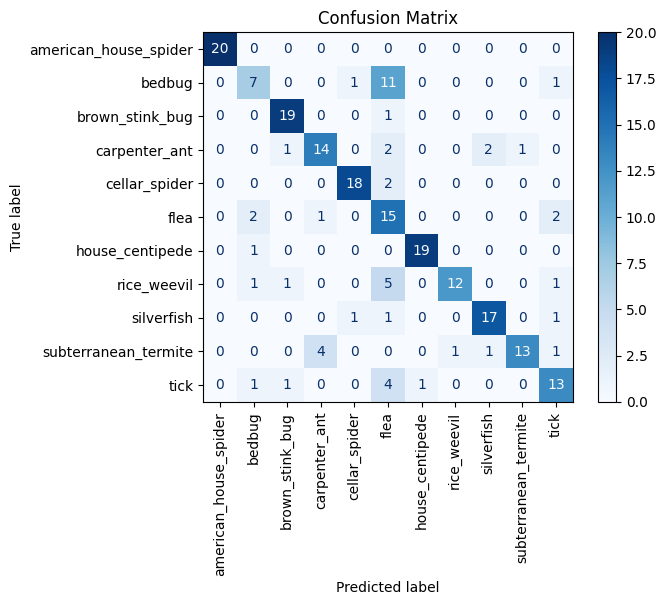

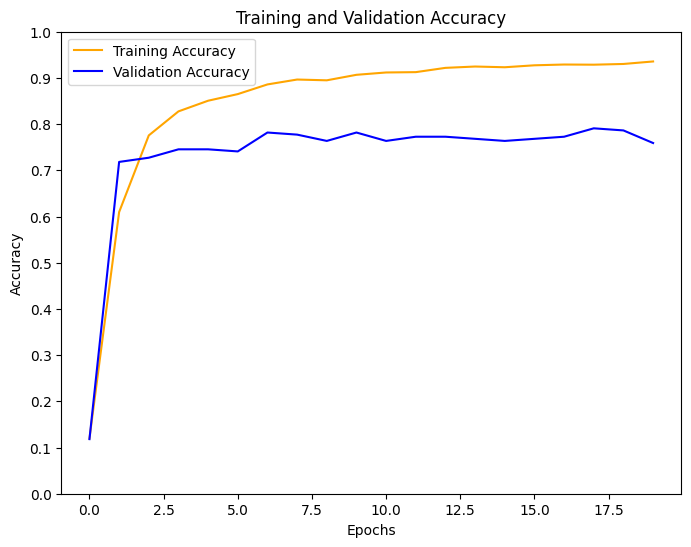

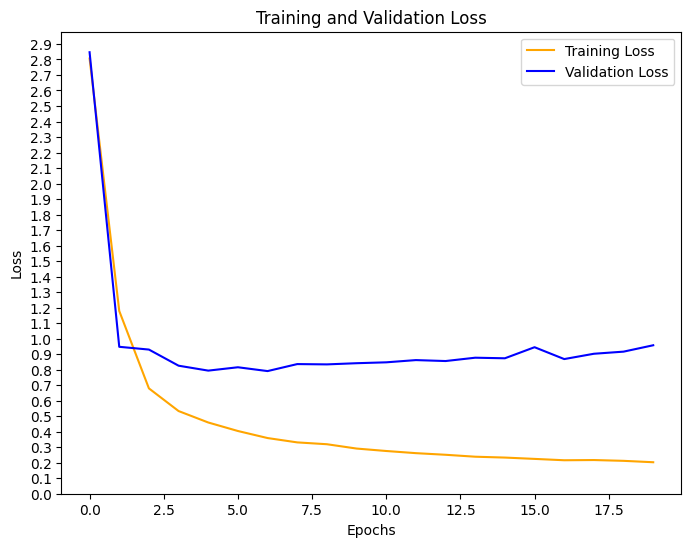

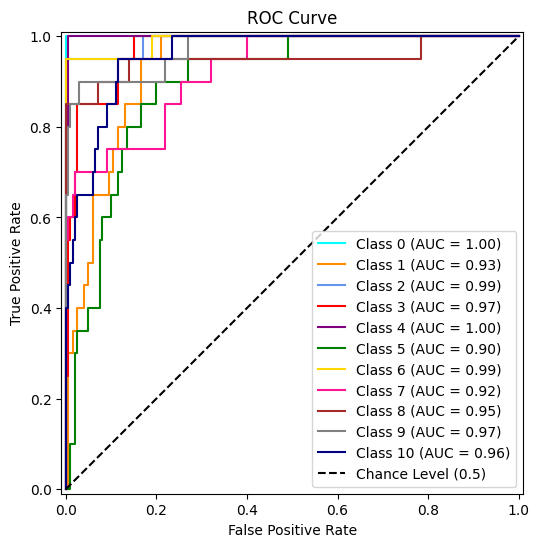

Macro-averaged One-vs-Rest ROC AUC score: 0.96
Accuracy: 0.759
Precision: 0.799
Recall: 0.759
F1 Score: 0.765


{'accuracy': 0.759,
 'precision': 0.799,
 'recall': 0.759,
 'f1_score': 0.765,
 'classification_report_df':                        precision    recall  f1-score     support
 american_house_spider   1.000000  1.000000  1.000000   20.000000
 bedbug                  0.583333  0.350000  0.437500   20.000000
 brown_stink_bug         0.863636  0.950000  0.904762   20.000000
 carpenter_ant           0.736842  0.700000  0.717949   20.000000
 cellar_spider           0.900000  0.900000  0.900000   20.000000
 flea                    0.365854  0.750000  0.491803   20.000000
 house_centipede         0.950000  0.950000  0.950000   20.000000
 rice_weevil             0.923077  0.600000  0.727273   20.000000
 silverfish              0.850000  0.850000  0.850000   20.000000
 subterranean_termite    0.928571  0.650000  0.764706   20.000000
 tick                    0.684211  0.650000  0.666667   20.000000
 accuracy                0.759091  0.759091  0.759091    0.759091
 macro avg               0.798684  

In [2]:
%matplotlib inline
evaluation_metrics(model, TEST_GENERATOR, history)


# Test metrics: 'accuracy': 0.759, 'precision': 0.799,'recall': 0.759, 'f1_score': 0.765
# NOTE: the accuracy and loss plotted in the blue lines here are the test data activing as validation data (just for observational purposes) since validation was morphed with training)